<a href="https://colab.research.google.com/github/rahilv99/Microbial_Optimization_Algorithim/blob/main/You_Lab_Growth_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTES ABOUT GENETIC ALGORITHIM
- The "genetic algorithm" part is NOT selecting the best medium, it is selecting the model that best reflects the relationships of the medium by cross validation (CV) testing
- May need to implement manifolds to improve CV testing


TO DO LIST
- change optimization model to better model the context of the problem
  - loss fcn is MSE right now
- find what training factors to evaluate on (not MSE)


In [2]:
!pip install pygad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.2 MB/s eta 0:00:00


Import libraries

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

import pygad
import pygad.gann
import pygad.nn

Process actual data from csv

In [ ]:
# Load dataset
df_growth = pd.read_csv('')

# print(df_bank.info())
print('Shape of dataframe:', df_growth.shape)
df_growth.head()

Read growth data distrubution
- May need to normalize growth factors to be 0 to 1 from min to max

In [ ]:
description = df_growth['numbers'].describe()

print(f"Range of 'numbers' column: {description['min']} - {description['max']}")
print(f"Standard deviation: {description['std']}")
print(f"Mean: {description['mean']}")

Split into factor and target data

In [ ]:
input_data = df_growth.drop('growth factor', axis=1)
target_data = df_growth['growth factor']

Create dummy data for demo

In [12]:
from google.colab import files
import csv
uploaded = files.upload()

filename = list(uploaded.keys())[0]

# Read the text file and store data in a list
data_list = []
with open(filename, newline='') as txtfile:
    txt_reader = csv.reader(txtfile, delimiter=',')
    for row in txt_reader:
        data_list.append(row)

# Convert the list of lists into a NumPy array (matrix)
data_matrix = np.array(data_list[1:])

# Define column names based on your data
column_names = ['Water Concentration (%)', 'Glucose Concentration (g/L)', 'CO2 Concentration (%)', 'Heat (°C)', 'pH', 'Growth Rate (OD600)']

# Create a Pandas DataFrame
data = pd.DataFrame(data=data_matrix, columns=column_names)

# Print the resulting matrix
print("Data Matrix:")
print(data.head())


Saving Dummy_Optimization_Data.txt to Dummy_Optimization_Data (4).txt
Data Matrix:
  Water Concentration (%) Glucose Concentration (g/L) CO2 Concentration (%)  \
0                      80                          10                     5   
1                      75                          15                     3   
2                      70                          12                     7   
3                      85                           8                     4   
4                      80                          10                     6   

  Heat (°C)   pH Growth Rate (OD600)  
0        30  7.0                0.45  
1        25  7.2                0.55  
2        35  7.0                0.63  
3        25  6.8                0.30  
4        30  7.0                0.40  


In [30]:
input_data = data.drop('Growth Rate (OD600)', axis=1)
target_data = data['Growth Rate (OD600)']
print("factors:")
print(input_data.head())
print("Growth Rate---")
print(target_data.head())

factors:
  Water Concentration (%) Glucose Concentration (g/L) CO2 Concentration (%)  \
0                      80                          10                     5   
1                      75                          15                     3   
2                      70                          12                     7   
3                      85                           8                     4   
4                      80                          10                     6   

  Heat (°C)   pH  
0        30  7.0  
1        25  7.2  
2        35  7.0  
3        25  6.8  
4        30  7.0  
Growth Rate---
0    0.45
1    0.55
2    0.63
3    0.30
4    0.40
Name: Growth Rate (OD600), dtype: object


Split into train and test data

In [33]:
# Standardize input data using scikit-learn
scaler = StandardScaler()
input_data_scaled = scaler.fit_transform(input_data)
target_data = target_data.values


print("factors:")
print(input_data_scaled)
print("Growth Rate")
print(target_data)

factors:
[[ 0.4802474  -0.91898358  0.18053954  0.40323892 -1.30246213]
 [-0.89188804  1.67302139 -1.40820838 -1.81457514  0.04596925]
 [-2.26402348  0.11781841  1.76928745  2.62105298 -1.30246213]
 [ 1.85238285 -1.95578556 -0.61383442 -1.81457514 -2.65089352]
 [ 0.4802474  -0.91898358  0.9749135   0.40323892 -1.30246213]
 [-0.89188804  1.67302139  0.18053954  1.29036454  0.04596925]
 [-0.06860677  0.11781841 -1.40820838 -0.4838867   2.06861633]
 [ 1.02910158 -0.91898358 -0.61383442 -0.4838867  -1.30246213]
 [-0.34303386  1.15462039  0.9749135   1.29036454  0.04596925]
 [ 0.20582032 -1.43738457  0.18053954 -0.04032389 -0.62824644]
 [-1.44074221  0.6362194  -0.61383442  0.84680173  0.72018494]
 [-0.61746095 -0.40058259  0.9749135   0.40323892  0.04596925]
 [ 0.75467449 -1.43738457 -1.40820838 -0.92744951  1.39440064]
 [-1.16631513  1.15462039  0.18053954 -0.4838867  -0.62824644]
 [ 0.20582032  0.11781841 -0.61383442 -1.37101233  0.72018494]
 [ 1.57795576 -0.40058259  0.9749135  -0.04032

Create instance of Pygad.GANN class (defines number of neural networks and their nodes, fcns, etc)
- this reflects current model in notebook
- this is our INITIAL POPULATION, number of solutions defined is starting population
- Can change # of nodes (increase for high bias, decrease for high variance)
- lambda in L2 (increase for high variance, decrease for high bias)
- Can add more layers (increase for high bias, decrease for high variance)

In [34]:
GANN_instance = pygad.gann.GANN(num_solutions= 6, # this is the number of models in the initial population
                                num_neurons_input= 5, # this is the number of features in the medium
                                num_neurons_hidden_layers=[16], # each index is each hidden layer's # of neurons
                                num_neurons_output=1, # output is the growth factor
                                hidden_activations=["relu"],
                                output_activation="None")


Get current population
- This function returns a list of references
- Each reference is a vector of weights in one of the solution ANNs
- Converts weight matrix of network to vector representation

In [35]:
population_vectors = pygad.gann.population_as_vectors(population_networks=GANN_instance.population_networks)

Create fitness function
- note: defines fitness of MODEL (multiple models created from Pygad.GANN)
- INPUT: solution, solution index
- OUTPUT: fitness of soltution (numerical)

- I THINK "predict" function runs the training data through the network and returns estimated growth factor
- **current implementation calculates MSE of predicted vs expected data**

In [56]:
def fitness_func(ga_instance, solution, sol_idx):
    global GANN_instance, input_data_scaled, target_data

    predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[sol_idx], data_inputs=input_data_scaled, problem_type="regression")

    solution_fitness = 1/mean_squared_error(target_data, predictions)

    return solution_fitness

Create generation callback function
- update prediction of output by changing weights of the ANNs in the population
- executes on each new generation

In [42]:
def callback_generation(ga_instance):
    global GANN_instance

    population_matrices = pygad.gann.population_as_matrices(population_networks=GANN_instance.population_networks, population_vectors=ga_instance.population)
    GANN_instance.update_population_trained_weights(population_trained_weights=population_matrices)

    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness    = {ga_instance.best_solution()[1]}")

Create instance of Pygad.GA class
- this reflects the "genetic algorithim part" (selection, breeding, mutation, etc)
- default values right now

In [57]:
initial_population = population_vectors.copy()

ga_instance = pygad.GA(num_generations= 500,  # number of times to run GA algorithim
                       num_parents_mating= 4, # number of models selected from population to exchange genes for next gen
                       initial_population=initial_population, # vector of initial population growth factors
                       fitness_func=fitness_func,
                       mutation_percent_genes= 5, # edit to have more or less crossover
                       init_range_low= -1, #idk what this does
                       init_range_high= 1, #idk what this does
                       parent_selection_type= "rws", # selects based on growth factor (higher % chance of selecting higher growth factor model)
                       crossover_type= "uniform",
                       mutation_type= "random",
                       keep_parents= 2,
                       on_generation=callback_generation)

ga_instance.run()


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation = 1
Fitness    = 7.665376297996283
Generation = 2
Fitness    = 6.003764653051799
Generation = 3
Fitness    = 6.261781929260709
Generation = 4
Fitness    = 7.541296884853357
Generation = 5
Fitness    = 9.62230772961142
Generation = 6
Fitness    = 11.959285936769936
Generation = 7
Fitness    = 11.959285936769936
Generation = 8
Fitness    = 11.959285936769936
Generation = 9
Fitness    = 11.959285936769936
Generation = 10
Fitness    = 11.959285936769936
Generation = 11
Fitness    = 11.959285936769936
Generation = 12
Fitness    = 11.959285936769936
Generation = 13
Fitness    = 11.959285936769936
Generation = 14
Fitness    = 11.959285936769936
Generation = 15
Fitness    = 11.959285936769936
Generation = 16
Fitness    = 11.959285936769936
Generation = 17
Fitness    = 11.959285936769936
Generation = 18
Fitness    = 11.959285936769936
Generation = 19
Fitness    = 11.959285936769936
Generation = 20
Fitness    = 11.959285936769936
Generation = 21
Fitness    = 11.959285936769936
Generat

Plot fitness of population

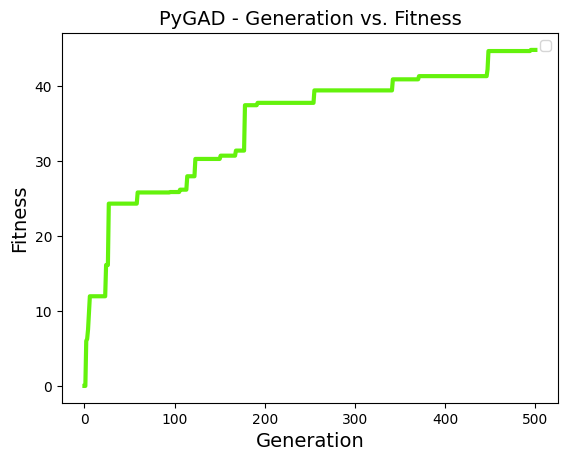

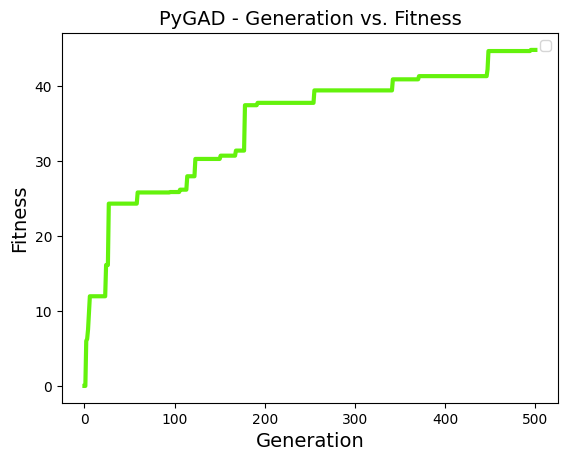

In [58]:
ga_instance.plot_fitness()

Use Best Model
- Return best model, find values that optimize growth factor

In [48]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness}")
print(f"Index of the best solution : {solution_idx}")

# This predicts the growth factor of a given medium (in data inputs)

predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[solution_idx], data_inputs=input_data_scaled)
print(f"MSE of the trained network : {predictions}")

Parameters of the best solution : [-1.33604143 -1.03459884  3.48077343  1.75704947  1.39524809 -2.71000647
 -0.86224971  1.15500894  4.55163658 -2.29080779  0.98511389  0.73350225
  0.83566884  0.99998125 -0.71714369  6.00517167  2.86260166  2.90451311
 -0.85890039  4.60864106  2.32924952  0.09198324  0.25494204  0.12873301
  1.84115066  3.44409826  2.08270222  1.86904046 -1.16958581  0.33935025
  1.76942194  0.99698785 -2.34666647  2.08039605 -1.52900655 -3.06145178
 -0.35505718 -2.73634888  1.02103424  5.04970834 -5.38282859  0.09141129
 -2.24400681  1.78098776  0.36654362  2.11318899  1.66104698  0.63570658
  1.0189959  -2.09605185  0.28482843  1.66111111  1.33184256  0.4217719
 -0.87540226 -1.24795435 -3.06332406  0.18274863 -1.81742723 -0.65855974
 -1.46084592  3.25607011  0.1773785   5.60468951 -4.6138829  -0.5409188
  1.8152238  -0.7355051   2.22909128  2.7993258   0.796778   -1.87561422
  3.52293136  2.74806074 -1.1284575   2.2099253   0.44676065 -1.54071461
  3.1674521   2.382